In [ ]:
# 🎯 Optimasi Clustering untuk Sistem Rekomendasi Game

Notebook ini dibuat untuk mencari jumlah cluster yang optimal untuk membuat sistem rekomendasi dari dataset games.csv.

## 📋 Objektif:
1. **Eksplorasi Data Games** - Memahami karakteristik dataset
2. **Feature Engineering** - Mempersiapkan fitur untuk clustering
3. **Evaluasi Cluster** - Menggunakan berbagai metrik untuk menentukan k optimal
4. **Visualisasi Hasil** - Menampilkan hasil analisis clustering

## 🔬 Metode yang Digunakan:
- **Elbow Method** - Mencari titik "siku" dalam kurva inertia
- **Silhouette Analysis** - Mengukur kualitas clustering
- **Calinski-Harabasz Index** - Evaluasi rasio varians
- **Davies-Bouldin Index** - Mengukur separasi cluster

---


In [1]:
# Import Libraries yang Diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Clustering libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Set style untuk plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Semua library berhasil di-import")
print("📊 Siap untuk analisis clustering!")


✅ Semua library berhasil di-import
📊 Siap untuk analisis clustering!


In [2]:
## 📂 1. Loading dan Eksplorasi Data


In [4]:
# Load dataset games.csv
df = pd.read_csv('./games.csv')

print(f"📊 Dataset Shape: {df.shape}")
print(f"🎮 Total Games: {df.shape[0]:,}")
print(f"📋 Total Features: {df.shape[1]}")
print("\n" + "="*50)
print("📋 Info Dataset:")
print(df.info())
print("\n" + "="*50)
print("📊 Sample Data:")
print(df.head())


📊 Dataset Shape: (50872, 13)
🎮 Total Games: 50,872
📋 Total Features: 13

📋 Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB
None

📊 Sample Data:
   app_id                          

In [5]:
# Analisis missing values dan statistik deskriptif
print("🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\n" + "="*50)
print("📈 Statistik Deskriptif untuk Kolom Numerik:")
print(df.describe())

print("\n" + "="*50)
print("🏷️ Kategori Rating yang Tersedia:")
print(df['rating'].value_counts())

print("\n" + "="*50)
print("💰 Distribusi Harga:")
price_stats = df['price_final'].describe()
print(price_stats)


🔍 Missing Values:
Series([], dtype: int64)

📈 Statistik Deskriptif untuk Kolom Numerik:
             app_id  positive_ratio  user_reviews   price_final  \
count  5.087200e+04    50872.000000  5.087200e+04  50872.000000   
mean   1.055224e+06       77.052033  1.824425e+03      8.620325   
std    6.103249e+05       18.253592  4.007352e+04     11.514164   
min    1.000000e+01        0.000000  1.000000e+01      0.000000   
25%    5.287375e+05       67.000000  1.900000e+01      0.990000   
50%    9.860850e+05       81.000000  4.900000e+01      4.990000   
75%    1.524895e+06       91.000000  2.060000e+02     10.990000   
max    2.599300e+06      100.000000  7.494460e+06    299.990000   

       price_original      discount  
count    50872.000000  50872.000000  
mean         8.726788      5.592212  
std         11.507021     18.606679  
min          0.000000      0.000000  
25%          0.990000      0.000000  
50%          4.990000      0.000000  
75%         11.990000      0.000000  
max 

In [6]:
## 🔧 2. Data Preprocessing dan Feature Engineering


In [7]:
# Membuat copy dataset untuk preprocessing
df_processed = df.copy()

# Handle missing values
print("🧹 Membersihkan Missing Values...")

# Isi missing values untuk kolom numerik dengan median
numeric_cols = ['positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount']
for col in numeric_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())

# Isi missing values untuk kolom kategorik dengan mode
categorical_cols = ['rating']
for col in categorical_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])

print("✅ Missing values berhasil ditangani")
print(f"🔍 Missing values setelah cleaning: {df_processed.isnull().sum().sum()}")


🧹 Membersihkan Missing Values...
✅ Missing values berhasil ditangani
🔍 Missing values setelah cleaning: 0


In [8]:
# Feature Engineering untuk Clustering
print("⚙️ Mempersiapkan fitur untuk clustering...")

# Encode rating menjadi nilai numerik
le_rating = LabelEncoder()
df_processed['rating_encoded'] = le_rating.fit_transform(df_processed['rating'])

# Buat fitur baru untuk platform support
df_processed['platform_count'] = df_processed['win'].astype(int) + df_processed['mac'].astype(int) + df_processed['linux'].astype(int)

# Buat kategori harga
def categorize_price(price):
    if price == 0:
        return 0  # Free
    elif price <= 5:
        return 1  # Budget
    elif price <= 20:
        return 2  # Mid-range
    elif price <= 50:
        return 3  # Premium
    else:
        return 4  # Expensive

df_processed['price_category'] = df_processed['price_final'].apply(categorize_price)

# Pilih fitur untuk clustering
clustering_features = [
    'positive_ratio',
    'user_reviews', 
    'price_final',
    'discount',
    'rating_encoded',
    'platform_count',
    'price_category',
    'steam_deck'
]

# Konversi boolean ke integer jika perlu
df_processed['steam_deck'] = df_processed['steam_deck'].astype(int)

# Buat dataset untuk clustering
X = df_processed[clustering_features].copy()

print("✅ Feature engineering selesai")
print(f"📊 Fitur yang akan digunakan untuk clustering: {len(clustering_features)}")
print(f"📋 Nama fitur: {clustering_features}")
print(f"🎮 Sample size untuk clustering: {X.shape[0]:,}")
print("\n📈 Preview fitur clustering:")
print(X.head())


⚙️ Mempersiapkan fitur untuk clustering...
✅ Feature engineering selesai
📊 Fitur yang akan digunakan untuk clustering: 8
📋 Nama fitur: ['positive_ratio', 'user_reviews', 'price_final', 'discount', 'rating_encoded', 'platform_count', 'price_category', 'steam_deck']
🎮 Sample size untuk clustering: 50,872

📈 Preview fitur clustering:
   positive_ratio  user_reviews  price_final  discount  rating_encoded  \
0              84          2199         9.99       0.0               8   
1              85            21         2.99       0.0               6   
2              92          3722        14.99       0.0               8   
3              61           873        14.99       0.0               0   
4              88          8784        11.99       0.0               8   

   platform_count  price_category  steam_deck  
0               1               2           1  
1               1               1           1  
2               3               2           1  
3               1             

In [9]:
# Normalisasi fitur
print("📏 Melakukan normalisasi fitur...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Normalisasi selesai")
print(f"📊 Shape data setelah scaling: {X_scaled.shape}")

# Cek statistik setelah scaling
print("\n📈 Statistik setelah scaling:")
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)
print(X_scaled_df.describe())


📏 Melakukan normalisasi fitur...
✅ Normalisasi selesai
📊 Shape data setelah scaling: (50872, 8)

📈 Statistik setelah scaling:
       positive_ratio  user_reviews   price_final      discount  \
count    5.087200e+04  5.087200e+04  5.087200e+04  5.087200e+04   
mean    -6.145597e-17  3.352144e-18 -7.654062e-17 -4.469525e-18   
std      1.000010e+00  1.000010e+00  1.000010e+00  1.000010e+00   
min     -4.221240e+00 -4.527785e-02 -7.486787e-01 -3.005516e-01   
25%     -5.506933e-01 -4.505326e-02 -6.626968e-01 -3.005516e-01   
50%      2.162865e-01 -4.430463e-02 -3.152952e-01 -3.005516e-01   
75%      7.641293e-01 -4.038679e-02  2.058072e-01 -3.005516e-01   
max      1.257188e+00  1.869741e+02  2.530557e+01  4.536469e+00   

       rating_encoded  platform_count  price_category    steam_deck  
count    5.087200e+04    5.087200e+04    5.087200e+04  5.087200e+04  
mean    -1.854853e-16    8.827312e-17    8.603836e-17  1.129114e-15  
std      1.000010e+00    1.000010e+00    1.000010e+00  1.000

In [ ]:
## 🔍 3. Menentukan Jumlah Cluster Optimal

Pada bagian ini, kita akan menggunakan beberapa metode untuk menentukan jumlah cluster yang optimal:
1. **Elbow Method** - Mencari titik infleksi pada kurva inertia
2. **Silhouette Analysis** - Mengukur seberapa baik clustering
3. **Calinski-Harabasz Index** - Rasio antara within-cluster dan between-cluster variance
4. **Davies-Bouldin Index** - Mengukur separasi dan kompaktitas cluster


In [10]:
# Fungsi untuk mengevaluasi clustering
def evaluate_clustering(X, max_k=15, sample_size=5000):
    """
    Evaluasi clustering dengan berbagai metrik untuk menentukan k optimal
    """
    # Sampling data untuk mempercepat proses (opsional untuk dataset besar)
    if len(X) > sample_size:
        print(f"🎯 Menggunakan sample {sample_size:,} data untuk evaluasi yang lebih cepat")
        sample_idx = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X[sample_idx]
    else:
        X_sample = X
    
    # Menyimpan metrik
    k_range = range(2, max_k + 1)
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    
    print("🔄 Melakukan evaluasi clustering...")
    print("⏱️ Proses ini mungkin memakan waktu beberapa menit...")
    
    for k in k_range:
        print(f"   Evaluating k={k}...", end=" ")
        
        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_sample)
        
        # Hitung metrik
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_sample, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(X_sample, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(X_sample, cluster_labels))
        
        print("✅")
    
    return {
        'k_range': list(k_range),
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores,
        'davies_bouldin_scores': davies_bouldin_scores
    }

# Jalankan evaluasi
print("🚀 Memulai evaluasi clustering...")
results = evaluate_clustering(X_scaled, max_k=15, sample_size=5000)
print("✅ Evaluasi selesai!")


🚀 Memulai evaluasi clustering...
🎯 Menggunakan sample 5,000 data untuk evaluasi yang lebih cepat
🔄 Melakukan evaluasi clustering...
⏱️ Proses ini mungkin memakan waktu beberapa menit...
   Evaluating k=2... ✅
   Evaluating k=3... ✅
   Evaluating k=4... ✅
   Evaluating k=5... ✅
   Evaluating k=6... ✅
   Evaluating k=7... ✅
   Evaluating k=8... ✅
   Evaluating k=9... ✅
   Evaluating k=10... ✅
   Evaluating k=11... ✅
   Evaluating k=12... ✅
   Evaluating k=13... ✅
   Evaluating k=14... ✅
   Evaluating k=15... ✅
✅ Evaluasi selesai!


In [ ]:
## 📊 4. Visualisasi Metrik Evaluasi Clustering


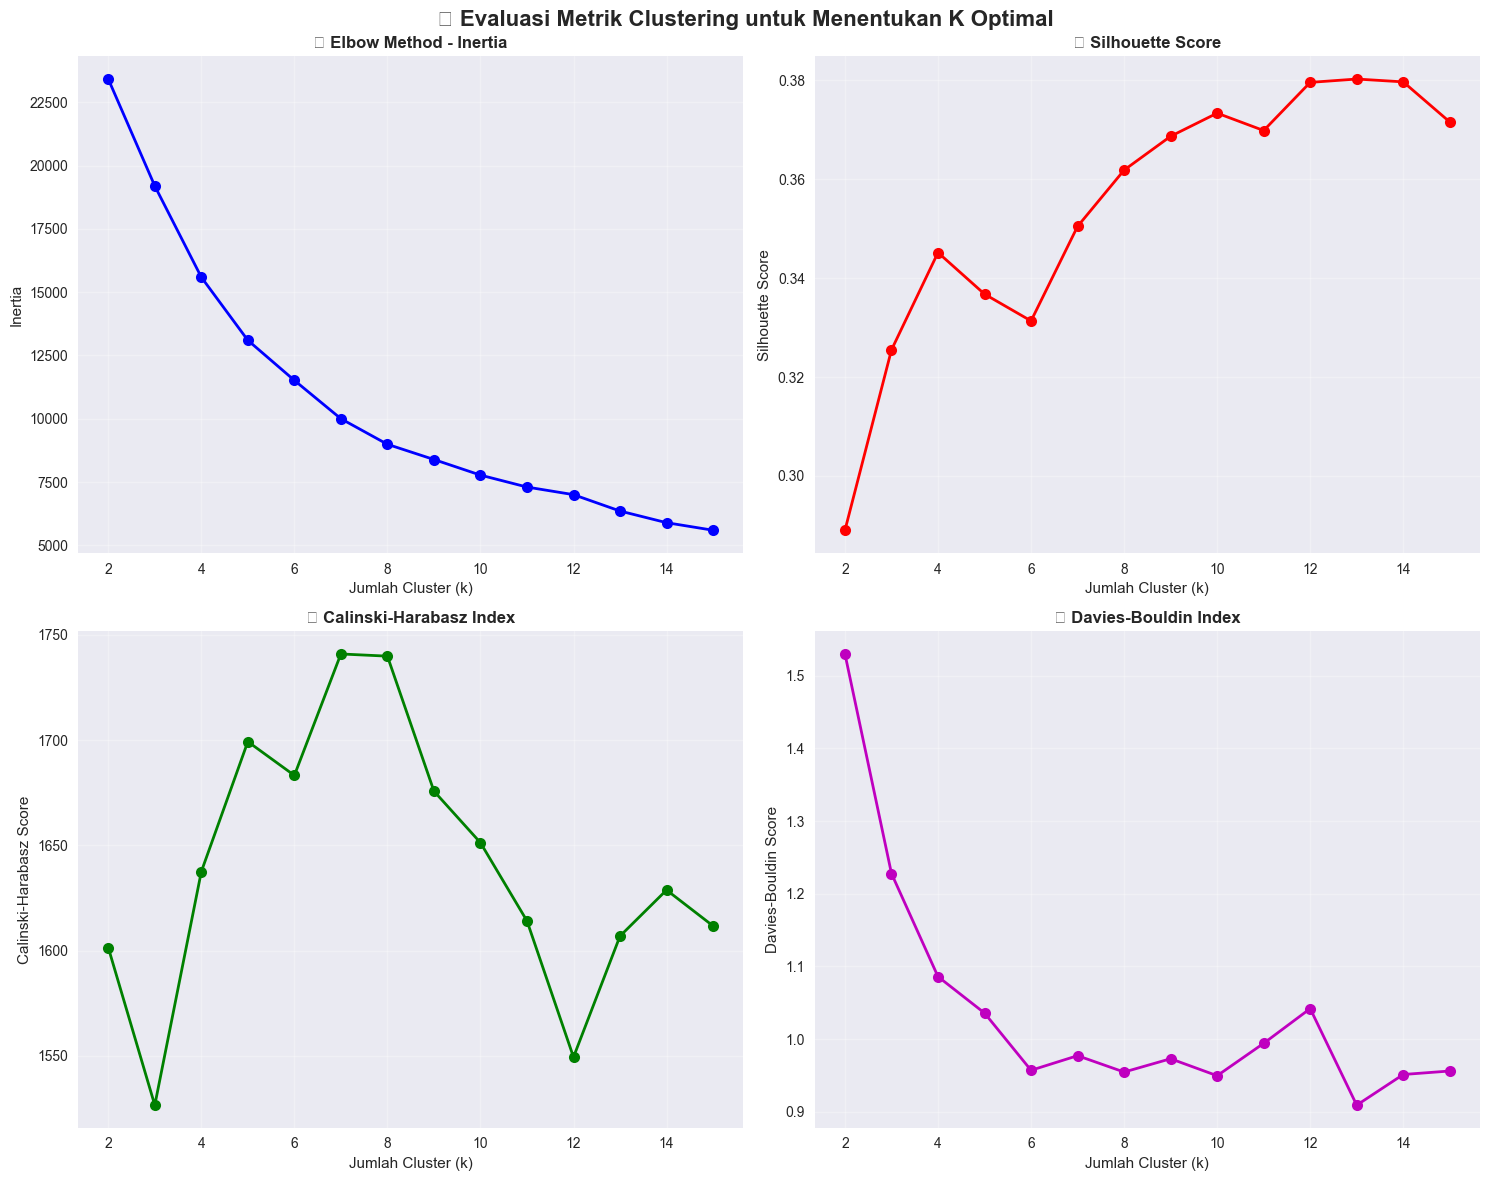

In [11]:
# Plotting semua metrik evaluasi clustering
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Evaluasi Metrik Clustering untuk Menentukan K Optimal', fontsize=16, fontweight='bold')

# 1. Elbow Method - Inertia
axes[0, 0].plot(results['k_range'], results['inertias'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('📈 Elbow Method - Inertia', fontweight='bold')
axes[0, 0].set_xlabel('Jumlah Cluster (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(True, alpha=0.3)

# 2. Silhouette Score
axes[0, 1].plot(results['k_range'], results['silhouette_scores'], 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_title('🎯 Silhouette Score', fontweight='bold')
axes[0, 1].set_xlabel('Jumlah Cluster (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].grid(True, alpha=0.3)

# 3. Calinski-Harabasz Index
axes[1, 0].plot(results['k_range'], results['calinski_scores'], 'go-', linewidth=2, markersize=8)
axes[1, 0].set_title('📊 Calinski-Harabasz Index', fontweight='bold')
axes[1, 0].set_xlabel('Jumlah Cluster (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].grid(True, alpha=0.3)

# 4. Davies-Bouldin Index
axes[1, 1].plot(results['k_range'], results['davies_bouldin_scores'], 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_title('📉 Davies-Bouldin Index', fontweight='bold')
axes[1, 1].set_xlabel('Jumlah Cluster (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# Analisis untuk menentukan k optimal berdasarkan setiap metrik
print("🔍 ANALISIS PENENTUAN K OPTIMAL")
print("="*60)

# 1. Elbow Method Analysis
print("\n📈 1. ELBOW METHOD ANALYSIS:")
print("   Mencari titik 'siku' dimana penurunan inertia mulai melambat")

# Hitung penurunan inertia antar k
inertia_diff = np.diff(results['inertias'])
inertia_diff_pct = np.abs(inertia_diff / results['inertias'][:-1] * 100)

print(f"   💡 Penurunan terbesar terjadi pada k=2->3: {inertia_diff_pct[0]:.1f}%")
print(f"   💡 Penurunan mulai melambat setelah k={results['k_range'][np.argmin(inertia_diff_pct)+2]}")

# 2. Silhouette Score Analysis
print("\n🎯 2. SILHOUETTE SCORE ANALYSIS:")
print("   Skor tinggi = clustering yang baik (rentang: -1 hingga 1)")
best_silhouette_k = results['k_range'][np.argmax(results['silhouette_scores'])]
best_silhouette_score = max(results['silhouette_scores'])
print(f"   ⭐ K optimal berdasarkan Silhouette: {best_silhouette_k} (score: {best_silhouette_score:.3f})")

# 3. Calinski-Harabasz Analysis
print("\n📊 3. CALINSKI-HARABASZ INDEX ANALYSIS:")
print("   Skor tinggi = clustering yang baik")
best_calinski_k = results['k_range'][np.argmax(results['calinski_scores'])]
best_calinski_score = max(results['calinski_scores'])
print(f"   ⭐ K optimal berdasarkan Calinski-Harabasz: {best_calinski_k} (score: {best_calinski_score:.1f})")

# 4. Davies-Bouldin Analysis
print("\n📉 4. DAVIES-BOULDIN INDEX ANALYSIS:")
print("   Skor rendah = clustering yang baik")
best_davies_k = results['k_range'][np.argmin(results['davies_bouldin_scores'])]
best_davies_score = min(results['davies_bouldin_scores'])
print(f"   ⭐ K optimal berdasarkan Davies-Bouldin: {best_davies_k} (score: {best_davies_score:.3f})")

print("\n" + "="*60)
print("🏆 REKOMENDASI K OPTIMAL:")
print(f"   🥇 Berdasarkan Silhouette Score: k = {best_silhouette_k}")
print(f"   🥈 Berdasarkan Calinski-Harabasz: k = {best_calinski_k}")
print(f"   🥉 Berdasarkan Davies-Bouldin: k = {best_davies_k}")

# Voting untuk k optimal
k_votes = [best_silhouette_k, best_calinski_k, best_davies_k]
from collections import Counter
k_vote_count = Counter(k_votes)
recommended_k = k_vote_count.most_common(1)[0][0]

print(f"\n🎯 REKOMENDASI FINAL: k = {recommended_k}")
print(f"   (Dipilih berdasarkan voting dari ketiga metrik)")
print("="*60)


🔍 ANALISIS PENENTUAN K OPTIMAL

📈 1. ELBOW METHOD ANALYSIS:
   Mencari titik 'siku' dimana penurunan inertia mulai melambat
   💡 Penurunan terbesar terjadi pada k=2->3: 18.0%
   💡 Penurunan mulai melambat setelah k=13

🎯 2. SILHOUETTE SCORE ANALYSIS:
   Skor tinggi = clustering yang baik (rentang: -1 hingga 1)
   ⭐ K optimal berdasarkan Silhouette: 13 (score: 0.380)

📊 3. CALINSKI-HARABASZ INDEX ANALYSIS:
   Skor tinggi = clustering yang baik
   ⭐ K optimal berdasarkan Calinski-Harabasz: 7 (score: 1740.9)

📉 4. DAVIES-BOULDIN INDEX ANALYSIS:
   Skor rendah = clustering yang baik
   ⭐ K optimal berdasarkan Davies-Bouldin: 13 (score: 0.909)

🏆 REKOMENDASI K OPTIMAL:
   🥇 Berdasarkan Silhouette Score: k = 13
   🥈 Berdasarkan Calinski-Harabasz: k = 7
   🥉 Berdasarkan Davies-Bouldin: k = 13

🎯 REKOMENDASI FINAL: k = 13
   (Dipilih berdasarkan voting dari ketiga metrik)


In [ ]:
## 🎯 5. Implementasi Clustering dengan K Optimal


In [13]:
# Implementasi clustering dengan k optimal
print(f"🚀 Menjalankan K-Means dengan k = {recommended_k}")

# Fit model dengan k optimal pada seluruh dataset
final_kmeans = KMeans(n_clusters=recommended_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Tambahkan label cluster ke dataset asli
df_processed['cluster'] = cluster_labels

print(f"✅ Clustering selesai!")
print(f"📊 Distribusi cluster:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"   Cluster {cluster_id}: {count:,} games ({percentage:.1f}%)")

# Hitung final metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_calinski = calinski_harabasz_score(X_scaled, cluster_labels)
final_davies = davies_bouldin_score(X_scaled, cluster_labels)

print(f"\n📈 Final Clustering Metrics:")
print(f"   Silhouette Score: {final_silhouette:.3f}")
print(f"   Calinski-Harabasz: {final_calinski:.1f}")
print(f"   Davies-Bouldin: {final_davies:.3f}")


🚀 Menjalankan K-Means dengan k = 13
✅ Clustering selesai!
📊 Distribusi cluster:
   Cluster 0: 2,350 games (4.6%)
   Cluster 1: 8,941 games (17.6%)
   Cluster 2: 3,568 games (7.0%)
   Cluster 3: 7,034 games (13.8%)
   Cluster 4: 4,114 games (8.1%)
   Cluster 5: 9,072 games (17.8%)
   Cluster 6: 1 games (0.0%)
   Cluster 7: 2 games (0.0%)
   Cluster 8: 4,048 games (8.0%)
   Cluster 9: 6,927 games (13.6%)
   Cluster 10: 497 games (1.0%)
   Cluster 11: 28 games (0.1%)
   Cluster 12: 4,290 games (8.4%)

📈 Final Clustering Metrics:
   Silhouette Score: 0.365
   Calinski-Harabasz: 17944.3
   Davies-Bouldin: 0.815


In [ ]:
## 📊 6. Analisis Karakteristik Cluster


In [14]:
# Analisis karakteristik setiap cluster
print("🔍 ANALISIS KARAKTERISTIK CLUSTER")
print("="*60)

for cluster_id in sorted(df_processed['cluster'].unique()):
    cluster_data = df_processed[df_processed['cluster'] == cluster_id]
    print(f"\n🎯 CLUSTER {cluster_id} ({len(cluster_data):,} games):")
    print("-" * 40)
    
    # Statistik harga
    print(f"💰 Harga rata-rata: ${cluster_data['price_final'].mean():.2f}")
    print(f"💰 Range harga: ${cluster_data['price_final'].min():.2f} - ${cluster_data['price_final'].max():.2f}")
    
    # Rating dan reviews
    print(f"⭐ Rating terpopuler: {cluster_data['rating'].mode().iloc[0] if not cluster_data['rating'].mode().empty else 'N/A'}")
    print(f"👥 Rata-rata user reviews: {cluster_data['user_reviews'].mean():.0f}")
    print(f"😊 Positive ratio rata-rata: {cluster_data['positive_ratio'].mean():.1f}%")
    
    # Platform support
    platform_support = {
        'Windows': cluster_data['win'].sum(),
        'Mac': cluster_data['mac'].sum(), 
        'Linux': cluster_data['linux'].sum(),
        'Steam Deck': cluster_data['steam_deck'].sum()
    }
    print(f"🖥️ Platform support: {platform_support}")
    
    # Contoh games dalam cluster
    sample_games = cluster_data[['title', 'price_final', 'rating', 'positive_ratio']].head(3)
    print(f"🎮 Sample games:")
    for _, game in sample_games.iterrows():
        print(f"   • {game['title'][:50]}... - ${game['price_final']:.2f} ({game['rating']})")

print("\n" + "="*60)


🔍 ANALISIS KARAKTERISTIK CLUSTER

🎯 CLUSTER 0 (2,350 games):
----------------------------------------
💰 Harga rata-rata: $33.54
💰 Range harga: $20.69 - $54.99
⭐ Rating terpopuler: Very Positive
👥 Rata-rata user reviews: 5628
😊 Positive ratio rata-rata: 82.7%
🖥️ Platform support: {'Windows': np.int64(2344), 'Mac': np.int64(207), 'Linux': np.int64(60), 'Steam Deck': np.int64(2350)}
🎮 Sample games:
   • Dandelion - Wishes brought to you -... - $29.99 (Very Positive)
   • Buzz Aldrin's Space Program Manager... - $29.99 (Mostly Positive)
   • Rytmik Studio... - $29.99 (Very Positive)

🎯 CLUSTER 1 (8,941 games):
----------------------------------------
💰 Harga rata-rata: $1.68
💰 Range harga: $0.00 - $5.00
⭐ Rating terpopuler: Mixed
👥 Rata-rata user reviews: 633
😊 Positive ratio rata-rata: 59.7%
🖥️ Platform support: {'Windows': np.int64(8905), 'Mac': np.int64(451), 'Linux': np.int64(95), 'Steam Deck': np.int64(8941)}
🎮 Sample games:
   • Kanji Training Game... - $4.99 (Mostly Positive)
   • R

📊 Membuat visualisasi cluster dalam ruang 2D...


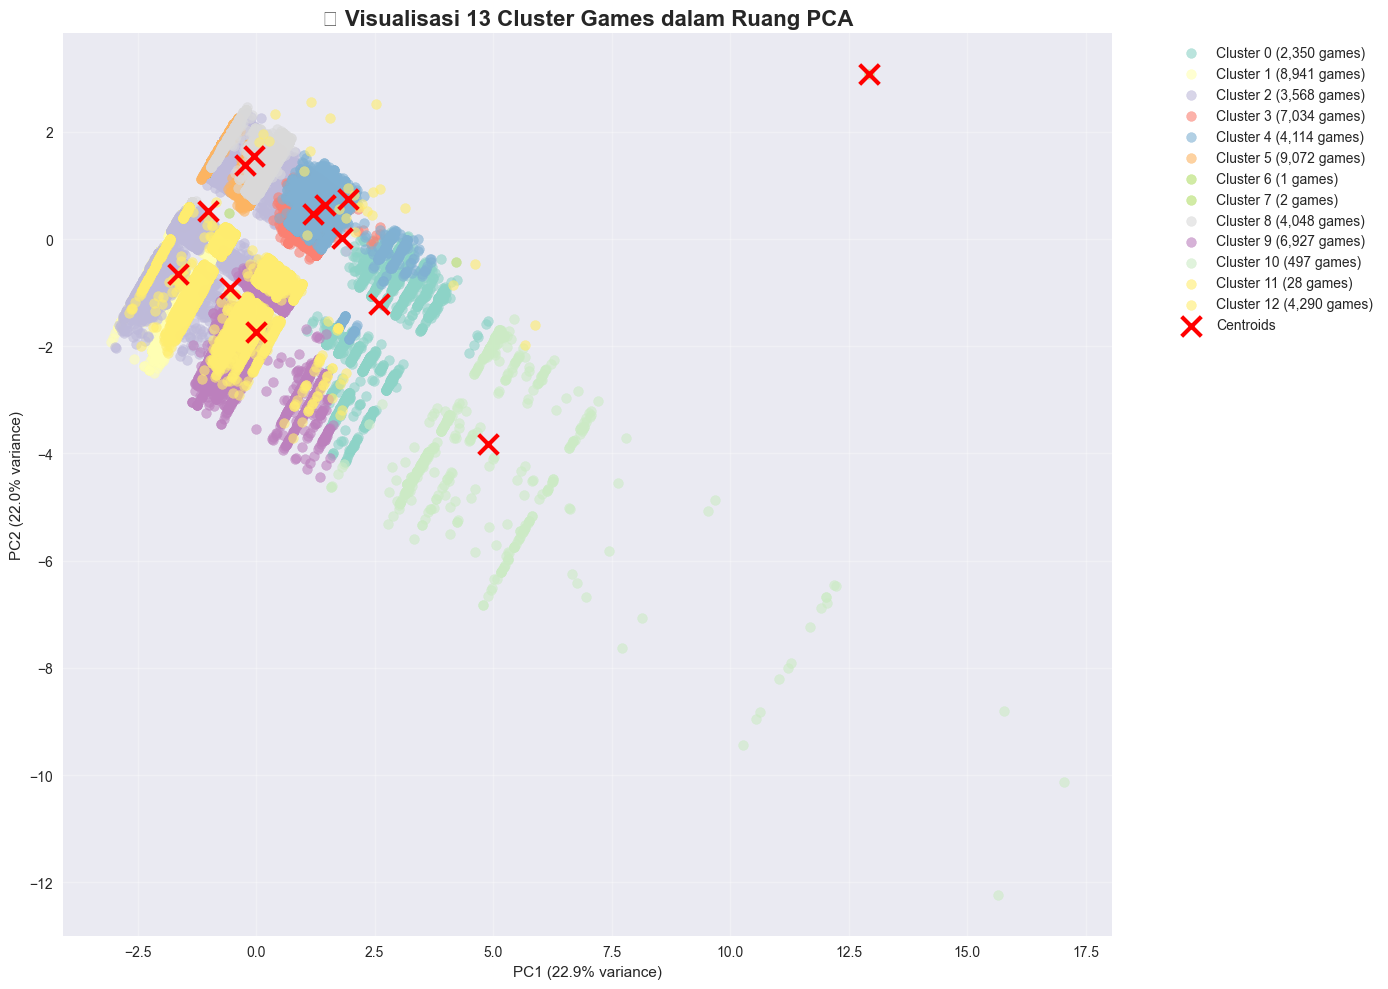

✅ Visualisasi selesai!
📊 Total variance yang dijelaskan oleh PC1 dan PC2: 44.9%


In [15]:
# Visualisasi cluster dalam 2D menggunakan PCA
print("📊 Membuat visualisasi cluster dalam ruang 2D...")

# Reduksi dimensi dengan PCA untuk visualisasi
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot cluster
plt.figure(figsize=(14, 10))

# Scatter plot untuk setiap cluster
colors = plt.cm.Set3(np.linspace(0, 1, recommended_k))
for i in range(recommended_k):
    cluster_points = X_pca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=[colors[i]], alpha=0.6, s=50, 
                label=f'Cluster {i} ({len(cluster_points):,} games)')

# Plot centroid
centroids_pca = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='red', marker='x', s=200, linewidths=3, 
            label='Centroids')

plt.title(f'🎯 Visualisasi {recommended_k} Cluster Games dalam Ruang PCA', 
          fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Visualisasi selesai!")
print(f"📊 Total variance yang dijelaskan oleh PC1 dan PC2: {sum(pca.explained_variance_ratio_):.1%}")
